# پیش‌بینی قیمت سهام به کمک MLP

به همراه تمرین اضافی (تست مدل‌های دیگر و دستیابی به دقت بالاتر)

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf       # https://pypi.org/project/yfinance/
import pytse_client as tse # https://pypi.org/project/pytse-client/

## دریافت داده

این بخش در تمرین شماره یک انجام گرفته و از همان کدها استفاده می‌شود.

دیتای اینتل و والمارت از api یاهوفایننس دریافت می‌شود:

In [68]:
tickers = ['INTC', 'WMT']
data_nse = yf.download(tickers, group_by = 'ticker', start="2017-01-01", end="2022-11-04")

[*********************100%***********************]  2 of 2 completed


دیتای دو سهم ایرانی شپنا و وبصادر نیز از سایت tse اسکریپ می‌شود:

In [101]:
tickers = ['وبصادر', 'شپنا']
prices_dict = tse.download(symbols=tickers, adjust=True)
prices_dict_reform = {(outerKey, innerKey):
                             values for outerKey, innerDict 
                             in prices_dict.items() for innerKey, values 
                             in innerDict.iteritems()}
data_tse = pd.DataFrame(prices_dict_reform)

## آشنایی با داده

نگاهی به دیتای شرکت اینتل می‌اندازیم:

In [70]:
data_nse['INTC'][['Open', 'High', 'Low', 'Close', 'Adj Close']].tail()

,Open,High,Low,Close,Adj Close
Date,,,,,
2022-10-28,28.180000,29.219999,27.860001,29.070000,28.682611
2022-10-31,29.080000,29.180000,28.049999,28.430000,28.051140
2022-11-01,28.799999,28.850000,27.889999,28.299999,27.922873
2022-11-02,28.270000,28.850000,27.410000,27.420000,27.054600
2022-11-03,27.450001,27.879999,27.170000,27.389999,27.025000


نگاهی به دیتای شرکت شپنا می‌اندازیم:

In [103]:
cols = ['open', 'high', 'low', 'close', 'adjClose']
data_tse['شپنا'].set_index('date')[cols].tail()

,open,high,low,close,adjClose
date,,,,,
2022-10-30,6090.0,6200.0,5990.0,6190.0,6110.0
2022-10-31,6150.0,6290.0,6120.0,6240.0,6210.0
2022-11-01,6260.0,6320.0,6190.0,6220.0,6240.0
2022-11-02,6240.0,6280.0,6190.0,6250.0,6240.0
2022-11-05,6300.0,6670.0,6300.0,6670.0,6630.0


نمودار شرکت اینتل را در یک سال آخر رسم می‌کنیم تا با حرکت کلی سهم آشنا شویم:

<AxesSubplot:title={'center':'Adj Close for INTC'}, xlabel='Date'>

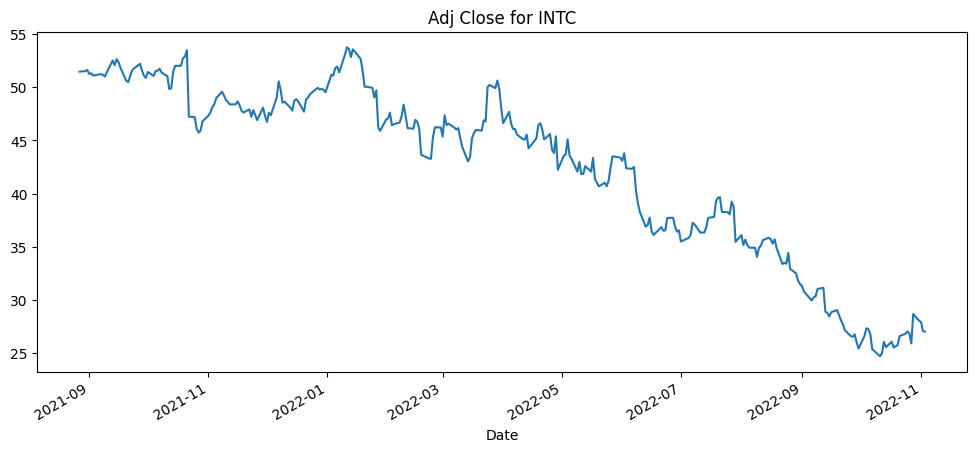

In [104]:
data_nse['INTC', 'Adj Close'][-300:].plot(title='Adj Close for INTC', figsize=(12,5))

مدل‌های رگرسیون مختلف را از sklearn ایمپورت می‌کنیم. جلوتر، در مورد مدل‌های استفاده شده بیشتر صحبت خواهد شد:

In [105]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_percentage_error

## مدل‌سازی
برای اینکه داده‌ها نرمالایز شوند، از دیفرنس لگاریتم طبیعی قیمت‌ها برای مدل‌سازی استفاده می‌شود.

تعداد لگ‌های ورودی، ۲۱ در نظر گرفته شده.

تعداد داده تست نیز ۲۰ انتخاب شده است.

باقی پارامترها، همان دیفالت sklearn هستند.

به جز یک مدل که اینجا با تگ MLP1 آورده می‌شود. پارامترهای این مدل، همان‌هایی است که در کلاس درس توسط استاد استفاده شد.

لیست مدل‌های استفاده شده در ادامه بحث آورده شده است.

## توابع کمکی

تابع lagmat را خودمان پیاده‌‌سازی می‌کنیم.

تعداد لگ به صورت دیفالت 21 انتخاب شده است.

In [106]:
def lagmat(df, T=21) -> (np.array, np.array):
    X = []
    Y = []
    df['DiffLogP'] = df['LogP'].diff()
    series = df['DiffLogP'].to_numpy()[1:]
    for t in range(len(series) - T):
        x = series[t:t+T]
        X.append(x)
        y = series[t+T]
        Y.append(y)

    X = np.array(X).reshape(-1 ,T)
    Y = np.array(Y)

    return X, Y

تابعی برای جدا کردن داده‌های آموزش و تست:

In [107]:
def get_train_test_set(df, test_count=20) -> (pd.DataFrame, pd.DataFrame):
    train_set = df[:-test_count]
    test_set = df[-test_count:]
    return train_set, test_set

تابع زیر، کار مدل‌سازی و پیش‌بینی را در سه نوع مختلف (تک‌گام، چندگام دینامیک و چندگام استاتیک) انجام می‌دهد.

برای اینکه بتوانیم مدل‌سازی را با استفاده از مدل‌های مختلف توسط این تابع انجام دهیم، یکی از ورودی‌های این تابع، خود مدل است.

ورودی دیگر تابع، تگ است که برای نام‌گذاری خروجی‌ها می‌تواند کمک‌کننده باشد.

توضیحات هر قسمت از کد، به صورت کامنت آورده شده:

In [108]:
def one_step_and_multistep_forecast(df, model, tag, test_count=20) -> pd.DataFrame:
    lags = 21   # number of lags to pass into lagmat function
    X, Y = lagmat(df, lags)

    # splitting the lagmat output to train and test
    x_train, y_train = X[:-test_count], Y[:-test_count]
    x_test, y_test = X[-test_count:], Y[-test_count:]
    # getting the train_set (different from x_train with 21 lags)
    train_set, _ = get_train_test_set(df)
    
    # fitting the model that was passed into the function with x_train and y_train
    model.fit(x_train, y_train)
    
    # storing the index of train and test dataset
    train_idx = df.index <= train_set.index[-1]
    test_idx = ~train_idx
    train_idx[:lags+1] = False

    df = pd.DataFrame(df)

    ### one step forecast
    # wee need to predict and undiffernce the result
    prev = df['LogP'].shift(1)
    df.loc[train_idx, f'{tag}_1step_train'] = \
        prev[train_idx] + model.predict(x_train)
    df.loc[test_idx, f'{tag}_1step_test'] = \
        prev[test_idx] + model.predict(x_test)

    ## multistep static forecast
    last_train = train_set.iloc[-1]['LogP']
    p = model.predict(x_test)
    df.loc[test_idx, f'{tag}_multistep_test_static'] = \
        last_train + np.cumsum(p)

    # multistep dynamic forecast
    multistep_predictions = []
    last_x = x_test[0]
    while len(multistep_predictions) < test_count:
        p = model.predict(last_x.reshape(1,-1))[0]

        multistep_predictions.append(p)

        last_x = np.roll(last_x, -1)
        last_x[-1] = p 
    
    last_train = train_set.iloc[-1]['LogP']
    df.loc[test_idx, f'{tag}_multistep_test'] = \
        last_train + np.cumsum(multistep_predictions)
    
    return df

این تابع را برای ساده کردن رسم نمودار مدل‌های مختلف تعریف می‌کنیم:

In [78]:
def plot(df, tag):
    df[['LogP', f'{tag}_1step_train', f'{tag}_1step_test',
         f'{tag}_multistep_test', f'{tag}_multistep_test_static']][-100:].plot(figsize=(15,8))

مدل‌سازی را توسط مدل SuuportVectorRegression بر روی قیمت پایانی سهام اینتل انجام می‌دهیم و نمودار خروجی را می‌کشیم:

نتیجه: در پیش‌بینی تک‌گام، به نظر می‌رسد که مقدار قبلی سری کپی می‌شود. در پیش‌بینی‌های چندگامه نیز، روند سری به اشتباه پیش‌بینی شده‌ است.

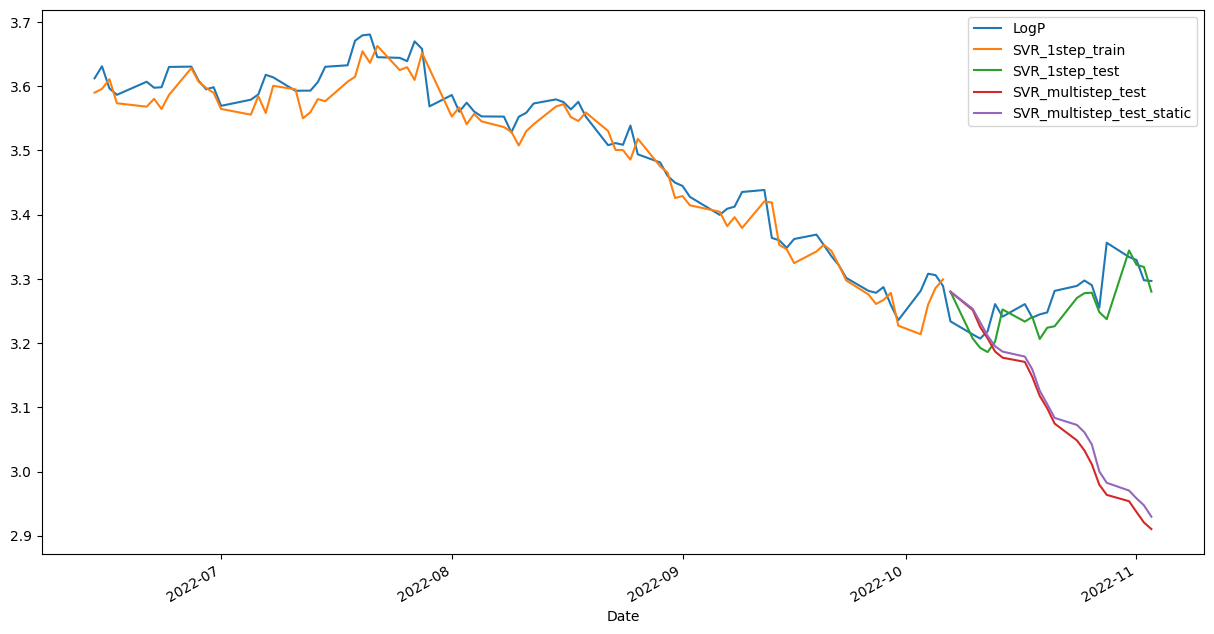

In [109]:
df_data = data_nse['INTC']
df_data = df_data[['Adj Close']]
df_data = df_data.rename({'Adj Close': 'P'}, axis=1)
df_data['LogP'] = np.log(df_data['P'])

svr_intc = one_step_and_multistep_forecast(df_data, SVR(), "SVR")
plot(svr_intc, tag="SVR")

مدل‌سازی را توسط مدل MultiLayerPerceptron بر روی قیمت پایانی سهام اینتل انجام می‌دهیم و نمودار خروجی را می‌کشیم:

نتیجه: در پیش‌بینی تک‌گام، به نظر می‌رسد که مقدار قبلی سری کپی می‌شود. در پیش‌بینی‌های چندگامه نیز، خروجی از مدل قبلی خطای کم‌تری دارد و توانسته به میانگین سری نزدیک شود.

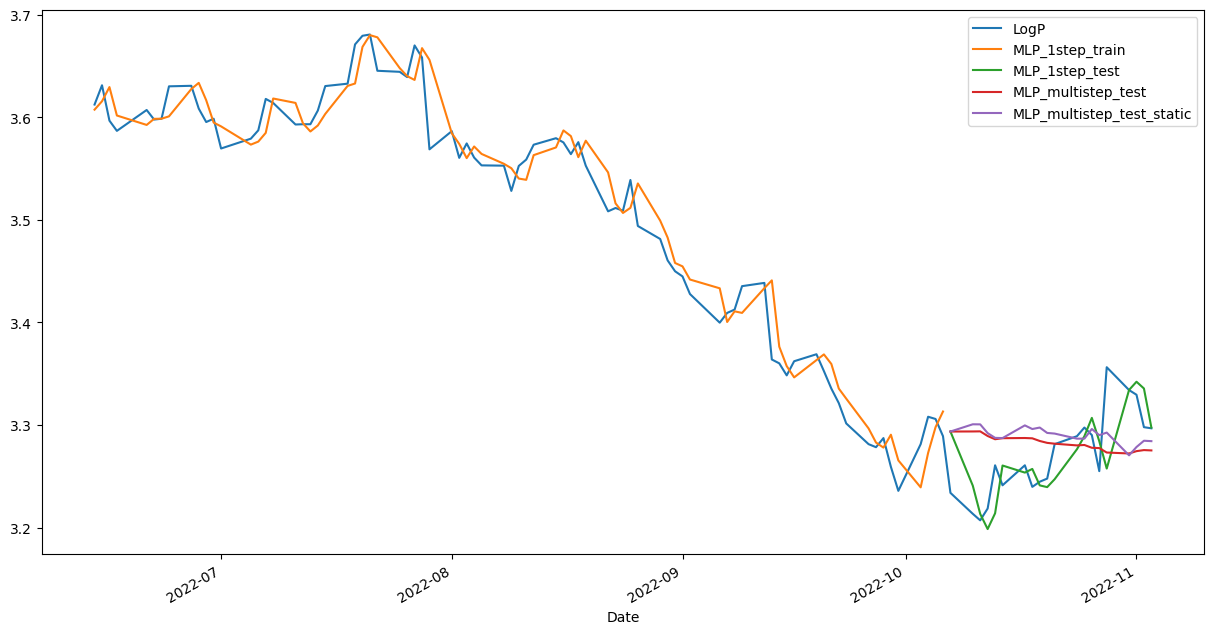

In [110]:
df_data = data_nse['INTC']
df_data = df_data[['Adj Close']]
df_data = df_data.rename({'Adj Close': 'P'}, axis=1)
df_data['LogP'] = np.log(df_data['P'])

mlp_intc = one_step_and_multistep_forecast(df_data, MLPRegressor(), "MLP")
plot(mlp_intc, "MLP")

مدل‌سازی را توسط مدل RandomForestRegression بر روی قیمت پایانی سهام اینتل انجام می‌دهیم و نمودار خروجی را می‌کشیم:

نتیجه: در پیش‌بینی تک‌گام، به نظر می‌رسد که مقدار قبلی سری کپی می‌شود. در پیش‌بینی‌های چندگامه نیز، خروجی بسیار به از مدل SVR بهتر است و توانسته به میانگین سری نزدیک شود.

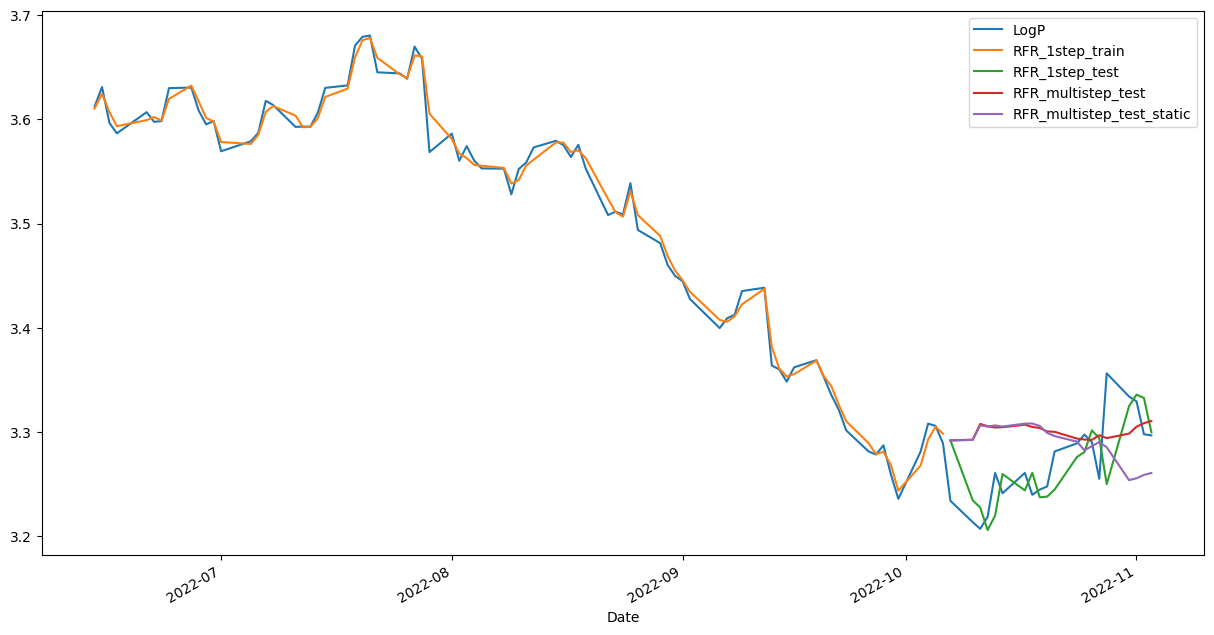

In [111]:
df_data = data_nse['INTC']
df_data = df_data[['Adj Close']]
df_data = df_data.rename({'Adj Close': 'P'}, axis=1)
df_data['LogP'] = np.log(df_data['P'])

rfr_intc = one_step_and_multistep_forecast(df_data, RandomForestRegressor(), "RFR")
plot(rfr_intc, "RFR")

مدل‌سازی را توسط مدل MLP بر روی قیمت پایانی سهام شپنا انجام می‌دهیم و نمودار خروجی را می‌کشیم:

نتیجه: در پیش‌بینی تک‌گام، به نظر می‌رسد که مقدار قبلی سری کپی می‌شود و در پیش‌بینی چندگام نیز، نتایج مطلوب به نظر می‌رسد.

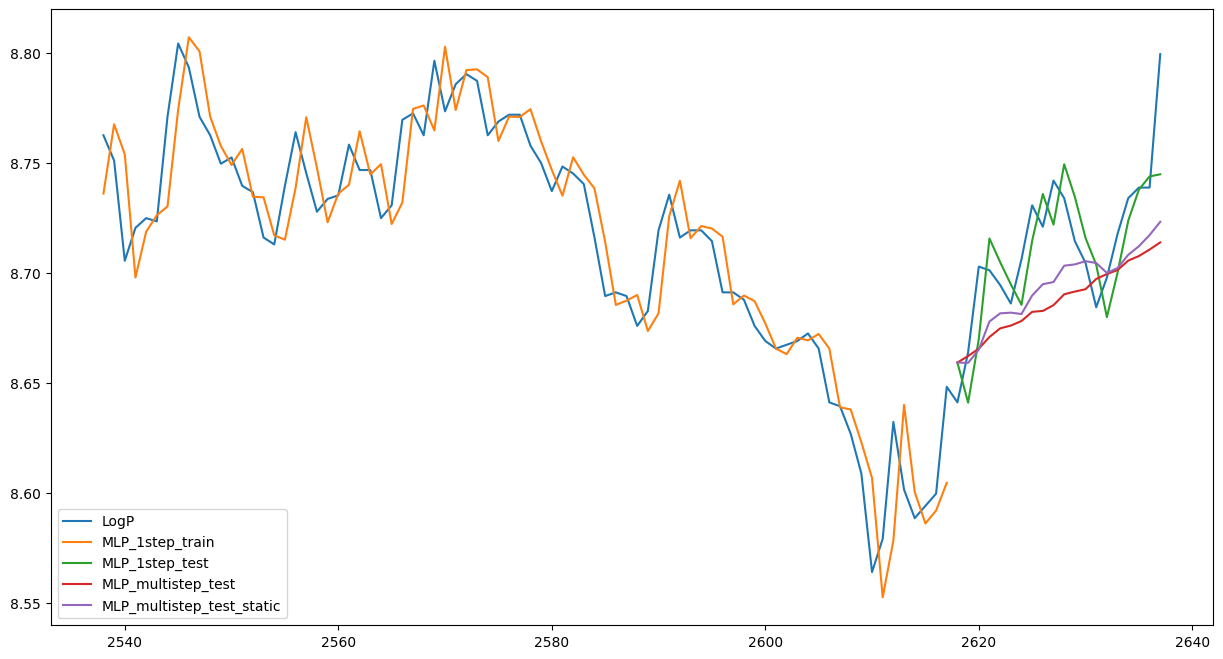

In [116]:
df_data = data_tse['شپنا']
df_data = df_data.rename({'adjClose': 'Adj Close'}, axis=1)
df_data = df_data[['Adj Close']].dropna()
df_data = df_data.rename({'Adj Close': 'P'}, axis=1)
df_data['LogP'] = np.log(df_data['P'])

mlp_shepna = one_step_and_multistep_forecast(df_data, MLPRegressor(), "MLP")
plot(mlp_shepna, tag="MLP")

## مقایسه مدل‌ها

معیار مقایسه مدل‌ها، خطای mape است. تابعی را به این منظور تعریف می‌کنیم:

In [117]:
def get_mape(df, tag, pred_tag, test_count=20):
    test_true = df.iloc[-test_count:]['LogP']
    test_pred = df.iloc[-test_count:][f'{tag}_{pred_tag}']
    mapel = mean_absolute_percentage_error(
        test_true, test_pred
    ) 
    return mapel

تا به اینجا کدها را طوری نوشته‌ایم که بتوانیم به سادگی، از مدل‌های مختلف در پکیج sklearn استفاده کنیم.

در این تمرین از پنج مدل استفاده می‌شود:

- رگرسیون خطی با تگ LR
  
- مدل MLP با پارامترهای استفاده شده توسط استاد در کلاس درس با تگ MLP1
  
- مدل MLP با پارامترهای دیفالت sklearn با تگ MLP2
  
- مدل SupportVectorRegression با تگ SVR
  
- مدل RandomForestRegressor با تگ RFR

In [118]:
models = [
    {'model': LinearRegression(), 'tag': 'LR'},
    {'model': MLPRegressor(hidden_layer_sizes=(100, 100), solver='lbfgs', activation='tanh', max_iter=1000), 'tag': 'MLP1'},
    {'model': MLPRegressor(), 'tag': 'MLP2'},
    {'model': SVR(), 'tag': 'SVR'},
    {'model': RandomForestRegressor(), 'tag': 'RFR'}
]

خطای mape مدل‌های بالا را برای شرکت اینتل محاسبه و در یک دیتافریم ذخیره می‌کنیم:

In [119]:
df_errors_intc = pd.DataFrame()
df_data = data_nse['INTC']
df_data = df_data[['Adj Close']]
df_data = df_data.rename({'Adj Close': 'P'}, axis=1)
df_data['LogP'] = np.log(df_data['P'])

for x in models:
    model = x['model']
    tag = x['tag']
    df_fitted = one_step_and_multistep_forecast(df_data, model, tag)
    df_errors_intc.loc[tag, 'multistep_dynamic'] = get_mape(df_fitted, tag=tag, pred_tag='multistep_test')
    df_errors_intc.loc[tag, 'multistep_static'] = get_mape(df_fitted, tag=tag, pred_tag='multistep_test_static')
    df_errors_intc.loc[tag, '1step'] = get_mape(df_fitted, tag=tag, pred_tag='1step_test')

دیتافریم خطا را پرینت می‌کنیم.

نتیجه:

- در پیش‌بینی تک‌گام، مدل RFR کم‌ترین خطا را دارد.
  
- در پیش‌بینی چندگام دینامیک، مدل RFR کم‌ترین خطا را دارد.
  
- در پیش‌بینی چندگام استاتیک مدل MLP با پارامترهای معرفی شده توسط استاد کم‌ترین خطا را دارد.

In [121]:
df_errors_intc

,multistep_dynamic,multistep_static,1step
LR,0.012190,0.013227,0.007466
MLP1,0.016182,0.012370,0.007769
MLP2,0.013807,0.014380,0.007539
SVR,0.059251,0.055270,0.008315
RFR,0.011616,0.014302,0.007179


خطای mape مدل‌های بالا را برای شرکت والمارت محاسبه و در یک دیتافریم ذخیره می‌کنیم:

In [122]:
df_errors_wmt = pd.DataFrame()
df_data = data_nse['WMT']
df_data = df_data[['Adj Close']]
df_data = df_data.rename({'Adj Close': 'P'}, axis=1)
df_data['LogP'] = np.log(df_data['P'])

for x in models:
    model = x['model']
    tag = x['tag']
    df_fitted = one_step_and_multistep_forecast(df_data, model, tag)
    df_errors_wmt.loc[tag, 'multistep_dynamic'] = get_mape(df_fitted, tag=tag, pred_tag='multistep_test')
    df_errors_wmt.loc[tag, 'multistep_static'] = get_mape(df_fitted, tag=tag, pred_tag='multistep_test_static')
    df_errors_wmt.loc[tag, '1step'] = get_mape(df_fitted, tag=tag, pred_tag='1step_test')

دیتافریم خطا را پرینت می‌کنیم.

نتیجه:

- در پیش‌بینی تک‌گام، مدل LR کم‌ترین خطا را دارد.
  
- در پیش‌بینی چندگام دینامیک، مدل MLP با پارامترهای دیفالت کم‌ترین خطا را دارد.
  
- در پیش‌بینی چندگام استاتیک، مدل MLP با پارامترهای دیفالت کم‌ترین خطا را دارد.

In [124]:
df_errors_wmt

,multistep_dynamic,multistep_static,1step
LR,0.006943,0.007609,0.002086
MLP1,0.007630,0.011928,0.002738
MLP2,0.006609,0.007390,0.002121
SVR,0.015592,0.013822,0.002361
RFR,0.006996,0.007894,0.002112


خطای mape مدل‌های بالا را برای شرکت شپنا محاسبه و در یک دیتافریم ذخیره می‌کنیم:

In [125]:
df_errors_shepna = pd.DataFrame()
df_data = data_tse['شپنا']
df_data = df_data.rename({'adjClose': 'Adj Close'}, axis=1)
df_data = df_data[['Adj Close']].dropna()
df_data = df_data.rename({'Adj Close': 'P'}, axis=1)
df_data['LogP'] = np.log(df_data['P'])

for x in models:
    model = x['model']
    tag = x['tag']
    df_fitted = one_step_and_multistep_forecast(df_data, model, tag)
    df_errors_shepna.loc[tag, 'multistep_dynamic'] = get_mape(df_fitted, tag=tag, pred_tag='multistep_test')
    df_errors_shepna.loc[tag, 'multistep_static'] = get_mape(df_fitted, tag=tag, pred_tag='multistep_test_static')
    df_errors_shepna.loc[tag, '1step'] = get_mape(df_fitted, tag=tag, pred_tag='1step_test')

دیتافریم خطا را پرینت می‌کنیم.

نتیجه:

- در پیش‌بینی تک‌گام، مدل MLP با پارامترهای دیفالت کم‌ترین خطا را دارد.
  
- در پیش‌بینی چندگام دینامیک، مدل RFR کم‌ترین خطا را دارد.
  
- در پیش‌بینی چندگام استاتیک، مدل RFR کم‌ترین خطا را دارد.

In [128]:
df_errors_shepna

,multistep_dynamic,multistep_static,1step
LR,0.004464,0.003784,0.002017
MLP1,0.004311,0.003659,0.002011
MLP2,0.006030,0.004908,0.001962
SVR,0.005153,0.008712,0.004400
RFR,0.003913,0.002607,0.002169


خطای mape مدل‌های بالا را برای شرکت وبصادر محاسبه و در یک دیتافریم ذخیره می‌کنیم:

In [129]:
df_errors_sader = pd.DataFrame()
df_data = data_tse['وبصادر']
df_data = df_data.rename({'adjClose': 'Adj Close'}, axis=1)
df_data = df_data[['Adj Close']].dropna()
df_data = df_data.rename({'Adj Close': 'P'}, axis=1)
df_data['LogP'] = np.log(df_data['P'])

for x in models:
    model = x['model']
    tag = x['tag']
    df_fitted = one_step_and_multistep_forecast(df_data, model, tag)
    df_errors_sader.loc[tag, 'multistep_dynamic'] = get_mape(df_fitted, tag=tag, pred_tag='multistep_test')
    df_errors_sader.loc[tag, 'multistep_static'] = get_mape(df_fitted, tag=tag, pred_tag='multistep_test_static')
    df_errors_sader.loc[tag, '1step'] = get_mape(df_fitted, tag=tag, pred_tag='1step_test')

دیتافریم خطا را پرینت می‌کنیم.

نتیجه:

- در پیش‌بینی تک‌گام مدل RFR کم‌ترین خطا را دارد.
  
- در پیش‌بینی چندگام دینامیک، مدل RFR کم‌ترین خطا را دارد.
  
- در پیش‌بینی چندگام استاتیک، مدل RFR کم‌ترین خطا را دارد.

In [131]:
df_errors_sader

,multistep_dynamic,multistep_static,1step
LR,0.011443,0.008502,0.001707
MLP1,0.012784,0.009670,0.001978
MLP2,0.008487,0.006732,0.001659
SVR,0.027860,0.027614,0.004898
RFR,0.005651,0.006004,0.001520


### نتیجه‌گیری

مدل RandomForestRegressor در بیشتر حالت‌ها بر مدل‌های دیگر ارجحیت دارد.

مدل SupportVectorRegressor در هیچ کدام از حالت‌ها، بهترین پیش‌بینی نبود و در بسیاری از مواقع حتی بیشترین خطا را داشت.
در ادبیات موضوع نیز، در مورد مشکل بیش‌برازش این مدل بسیار صحبت شده است.